In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import yaml

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer , CountVectorizer
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping


from joblib import dump

nltk.download('stopwords') # download stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
file = Path('/content/drive/MyDrive/virtual_yaml/intents.yaml')

In [ ]:
patterns_lst = []
tags_lst = []


# Read data from file
data_file = open(file).read()
intents = yaml.safe_load(data_file)

for intent in intents['intent']:
    for pattern in intent['patterns']:
        patterns_lst.append(pattern)
        tags_lst.append(intent['tag'])

dataset = {'Sentence':patterns_lst , 'Intent':tags_lst}

# Create dataframe
df = pd.DataFrame(data=dataset)
df.sample(10)

,Sentence,Intent
950,i want to hear is jazz,PlayMusic
856,how to make fried rice,Cooking
1002,please play my taylor swift mix,PlayMusic
37,"i had a pleasure talking to you, see you later",Goodbye
52,it was cool talking with you,Goodbye
1277,please set the alarm for next friday at 6 am,Reminder
981,play believer song,PlayMusic
1163,what alarms are set for this week,Reminder
1186,please remind me to call justin,Reminder
1138,tell me if my alarm is set for the morning,Reminder


In [ ]:
df.shape

(1298, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1298 non-null   object
 1   Intent    1298 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB


In [ ]:
print('Number of unique sentences:' , df['Sentence'].nunique())

Number of unique sentences: 1237


In [ ]:
print('Number of intents:' , df['Intent'].nunique())

Number of intents: 11


In [ ]:
print('List of intents:', df['Intent'].unique())

List of intents: ['Greeting' 'Goodbye' 'Thanks' 'Joke' 'Datetime' 'Weather' 'Iot' 'News'
 'Cooking' 'PlayMusic' 'Reminder']


In [ ]:
classes = sorted(list(set(df['Intent'])))
classes

['Cooking',
 'Datetime',
 'Goodbye',
 'Greeting',
 'Iot',
 'Joke',
 'News',
 'PlayMusic',
 'Reminder',
 'Thanks',
 'Weather']

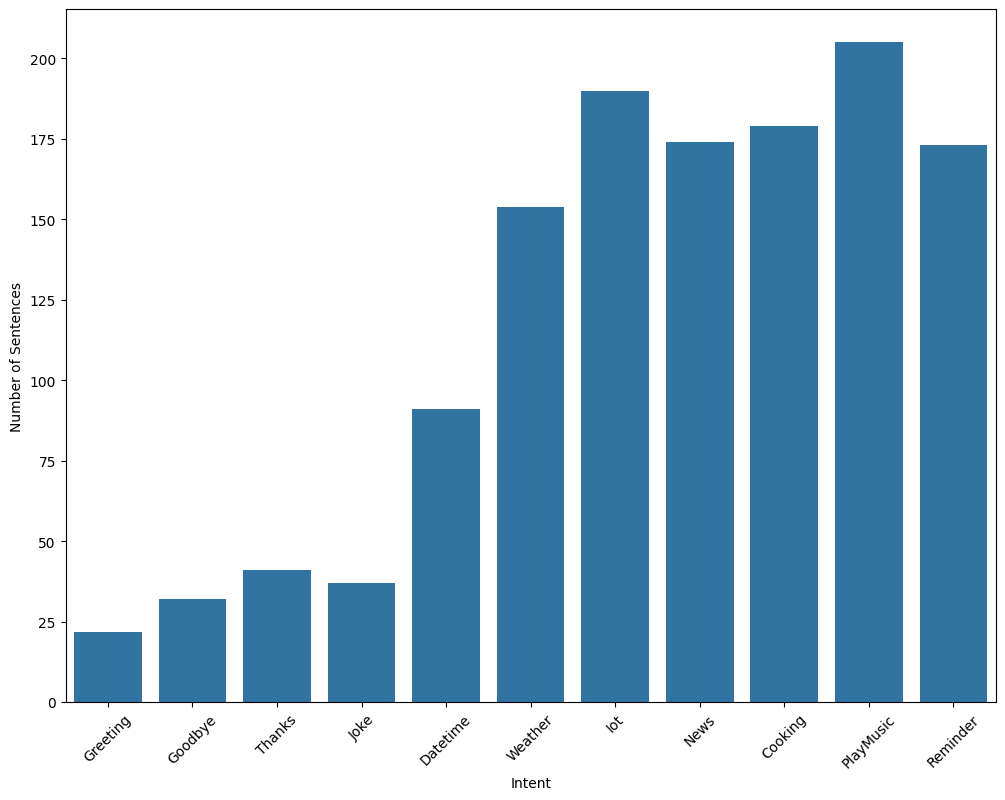

In [ ]:
plt.figure(figsize=(12,9))
sns.countplot(x = 'Intent' , data = df)
plt.xticks(rotation=45)
plt.ylabel('Number of Sentences')
plt.show()

In [ ]:
def preprocess(dataframe):
    data = []
    for i in range(dataframe.shape[0]):
        sentence = dataframe.iloc[i, 0]

        # remove non alphabatic characters
        sentence = re.sub('[^A-Za-z]', ' ', sentence)

        # make words lowercase
        sentence = sentence.lower()

        # tokenize words
        tokenized_sentence = word_tokenize(sentence)

        # remove stop words and lemmatize
        sentence_processed = []

        for word in tokenized_sentence:
            if word not in set(stopwords.words('english')):
                sentence_processed.append(lemma.lemmatize(word , pos='n')) # lemmatize words with noun

        sentence_text = " ".join([lemma.lemmatize(word, pos='v') for word in sentence_processed]) # lemmatize words with verb
        data.append(sentence_text)

    return data

## ML Model


In [ ]:

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
#preprocessing
X = preprocess(df)
y = df.iloc[:, 1]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2 , random_state=0 , stratify=y ,shuffle=True)

In [ ]:
svc_model = Pipeline([   ('vect', CountVectorizer(ngram_range=(1,2),max_features=1000,max_df=.70)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(random_state=0, tol=1e-5))
                     ]
                    )

svc_model.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

print('Training Accuracy:',round(svc_model.score(X_train,y_train)*100,2),'%')
print('Testing Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')

Training Accuracy: 99.33 %
Testing Accuracy: 98.85 %


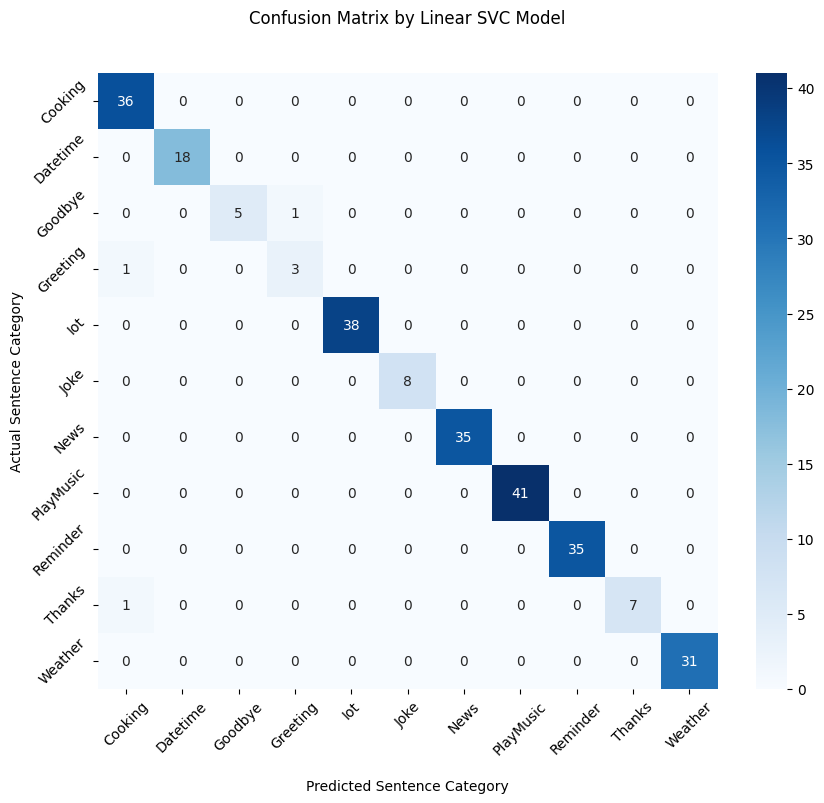

In [ ]:
matrix = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix by Linear SVC Model\n\n');
ax.set_xlabel('\nPredicted Sentence Category')
ax.set_ylabel('Actual Sentence Category');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [ ]:
nb_model = Pipeline([    ('vect', CountVectorizer(ngram_range=(1,2),max_df=.70)),
                         ('tfidf', TfidfTransformer()),
                         ('nb', MultinomialNB())
                    ]
                   )

nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print('Training Accuracy:',round(svc_model.score(X_train,y_train)*100,2),'%')
print('Testing Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')

Training Accuracy: 99.33 %
Testing Accuracy: 93.85 %


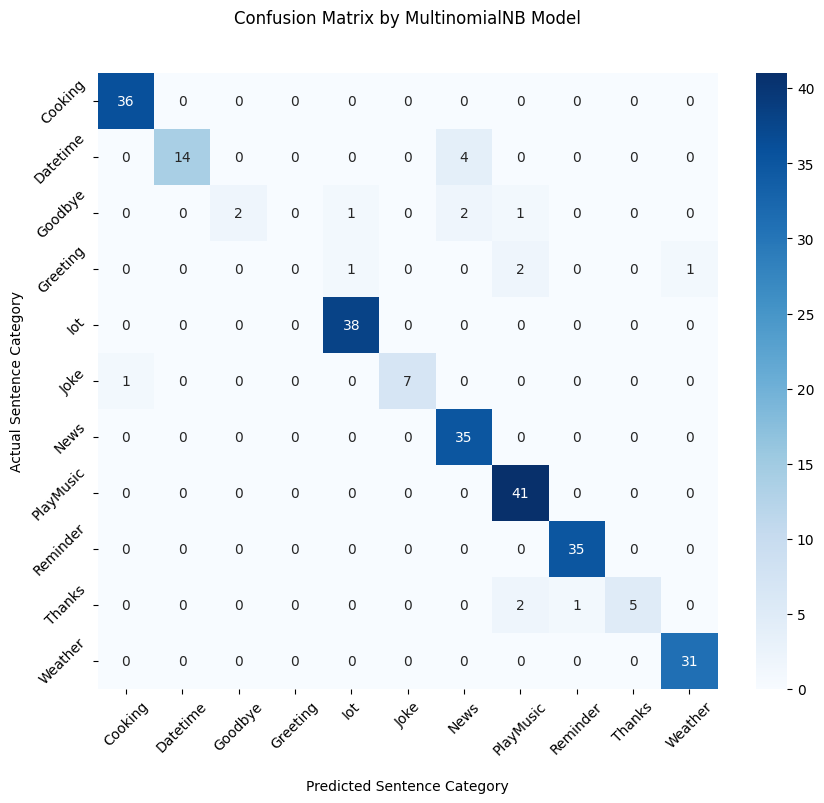

In [ ]:
matrix = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix by MultinomialNB Model\n\n');
ax.set_xlabel('\nPredicted Sentence Category')
ax.set_ylabel('Actual Sentence Category');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [ ]:
from joblib import dump

# Save the Scikit-learn pipeline model as a .joblib file
dump(svc_model, "SVC_Model.joblib")


['SVC_Model.joblib']

## DL Model

In [ ]:
token = Tokenizer()
token.fit_on_texts(preprocess(df))
words =  token.word_index
words

{'please': 1,
 'play': 2,
 'news': 3,
 'light': 4,
 'tell': 5,
 'weather': 6,
 'today': 7,
 'time': 8,
 'music': 9,
 'alarm': 10,
 'turn': 11,
 'set': 12,
 'recipe': 13,
 'make': 14,
 'song': 15,
 'latest': 16,
 'cook': 17,
 'go': 18,
 'like': 19,
 'bedroom': 20,
 'week': 21,
 'room': 22,
 'want': 23,
 'need': 24,
 'show': 25,
 'playlist': 26,
 'joke': 27,
 'thank': 28,
 'new': 29,
 'tomorrow': 30,
 'brightness': 31,
 'event': 32,
 'find': 33,
 'live': 34,
 'good': 35,
 'day': 36,
 'next': 37,
 'current': 38,
 'date': 39,
 'chicken': 40,
 'know': 41,
 'give': 42,
 'whats': 43,
 'put': 44,
 'happen': 45,
 'meet': 46,
 'hear': 47,
 'right': 48,
 'read': 49,
 'morning': 50,
 'forecast': 51,
 'get': 52,
 'world': 53,
 'let': 54,
 'temperature': 55,
 'heat': 56,
 'calendar': 57,
 'headline': 58,
 'rock': 59,
 'jazz': 60,
 'listen': 61,
 'york': 62,
 'medium': 63,
 'talk': 64,
 'bbc': 65,
 'call': 66,
 'remind': 67,
 'outside': 68,
 'add': 69,
 'remove': 70,
 'would': 71,
 'pm': 72,
 'pasta'

In [ ]:
vocab_size = len(token.word_index) + 1
vocab_size

762

In [ ]:
text = 'search about gold in google'
x = token.texts_to_sequences([text.split()])
print(x , '\n',np.array(x).shape)

[[337, 711, 361]] 
 (1, 3)


Using **Frequency** mode to prevent overfitting not like **TF-IDF** mode it doesn't make normailze


In [ ]:
y_encoded = np.array(df['Intent']).reshape(len(df), 1)
y_encoded.shape


(1298, 1)